In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
filepath = "Downtime/DOWNTIME_RJIL_BR_2025-09_ro_modified.xlsx"
df = pd.read_excel(filepath)
df.columns

Index(['service_provider_name', 'lsa_code', 'state_code', 'month_year', 'cgi',
       'district', 'pincode', 'technology', 'date_of_commissioning',
       'date_of_de_commissioning', '1-Sep', '2-Sep', '3-Sep', '4-Sep', '5-Sep',
       '6-Sep', '7-Sep', '8-Sep', '9-Sep', '10-Sep', '11-Sep', '12-Sep',
       '13-Sep', '14-Sep', '15-Sep', '16-Sep', '17-Sep', '18-Sep', '19-Sep',
       '20-Sep', '21-Sep', '22-Sep', '23-Sep', '24-Sep', '25-Sep', '26-Sep',
       '27-Sep', '28-Sep', '29-Sep', '30-Sep'],
      dtype='object')

In [41]:
filename = os.path.basename(filepath)
print("Loaded file:", filename)

cols = list(df.columns)

original_cols = cols.copy()


cols[10:] = np.arange(1, 31)  # --> change according to month days
df.columns = cols

date_cols = df.columns[10:]

Loaded file: DOWNTIME_RJIL_BR_2025-09_ro_modified.xlsx


In [42]:
df.columns

Index([   'service_provider_name',                 'lsa_code',
                     'state_code',               'month_year',
                            'cgi',                 'district',
                        'pincode',               'technology',
          'date_of_commissioning', 'date_of_de_commissioning',
                                1,                          2,
                                3,                          4,
                                5,                          6,
                                7,                          8,
                                9,                         10,
                               11,                         12,
                               13,                         14,
                               15,                         16,
                               17,                         18,
                               19,                         20,
                               21,                     

In [43]:
# --------------------------------------------
# 1) Updated process_row: count values > 0.00
# --------------------------------------------
def process_row(row):
    values = row[date_cols]

    # All numeric now — count values > 0
    nums = [v for v in values if isinstance(v, (int, float))]
    return sum(1 for n in nums if n > 0)


# --------------------------------------------
# 2) Apply function
# --------------------------------------------
df["Result"] = df.apply(process_row, axis=1)
df["num_Result"] = pd.to_numeric(df["Result"], errors="coerce")


# --------------------------------------------
# 3) Create Result_bin ranges
#    Bins: 0–10, 10–20, 20–30, 30+
# --------------------------------------------
bins = [0, 10, 20, 30, float("inf")]
labels = ["0–10", "10–20", "20–30", "30+"]

df["Result_bin"] = pd.cut(
    df["num_Result"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False     # left-inclusive: 0–10 means [0,10)
)

df["Result_bin"] = df["Result_bin"].astype(object)


# --------------------------------------------
# 4) Balanced sampling
# --------------------------------------------
stratified_cols = ["district", "technology", "Result_bin"]

def ensure_all_categories(df, col):
    """Take 1 sample per category in this column."""
    return df.groupby(col).sample(n=1, random_state=24)

blocks = []

for col in stratified_cols:
    blocks.append(ensure_all_categories(df, col))

base_sample = pd.concat(blocks).drop_duplicates()
print("Guaranteed coverage rows:", len(base_sample))


# --------------------------------------------
# 5) Fill the rest to reach 1500 rows
# --------------------------------------------
target_count = 500
remaining = target_count - len(base_sample)

extra_sample = df.drop(base_sample.index).sample(
    n=remaining,
    random_state=52
)

sampled_data = pd.concat([base_sample, extra_sample])
sampled_data = sampled_data.sample(frac=1, random_state=99).reset_index(drop=True)

sampled_data.drop(columns="num_Result", inplace=True)
sampled_data.to_excel(f"C:/Users/ID0468235/Downloads/Sample Down/sampled-{filename}", index=False)

Guaranteed coverage rows: 68


In [9]:
sampled_data.sample(5)

,service_provider_name,lsa_code,state_code,month_year,cgi,district,pincode,technology,date_of_commissioning,date_of_de_commissioning,...,24,25,26,27,28,29,30,31,Result,Result_bin
374,RJIL,AS,AS,2025-07-01,40585501B5724,Kamrup,781104.0,4G,2019-12-28,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0–10
117,RJIL,AS,AS,2025-07-01,405855002CB38,Dibrugarh,786622.0,4G,2016-06-24,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0–10
109,RJIL,AS,AS,2025-07-01,4058550068E30,Cachar,788007.0,4G,2015-12-23,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0–10
440,RJIL,AS,AS,2025-07-01,4058550115F30,Charaideo,785690.0,4G,2018-07-21,NaN,...,0.24,0.0,0.23,0.23,0.0,0.21,0.0,0.0,0,0–10
120,RJIL,AS,AS,2025-07-01,4058551239B4011,Dhemaji,787059.0,5G,2018-08-21,NaN,...,NVS,NVS,NVS,NVS,NVS,NVS,NVS,NVS,0,0–10


<Axes: xlabel='count', ylabel='Result_bin'>

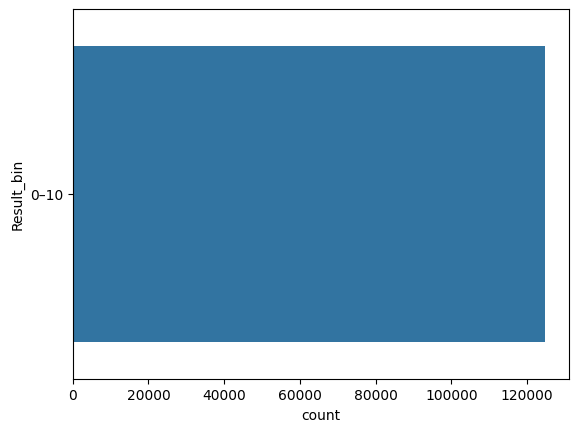

In [10]:
sns.countplot(df["Result_bin"])

<Axes: xlabel='count', ylabel='Result_bin'>

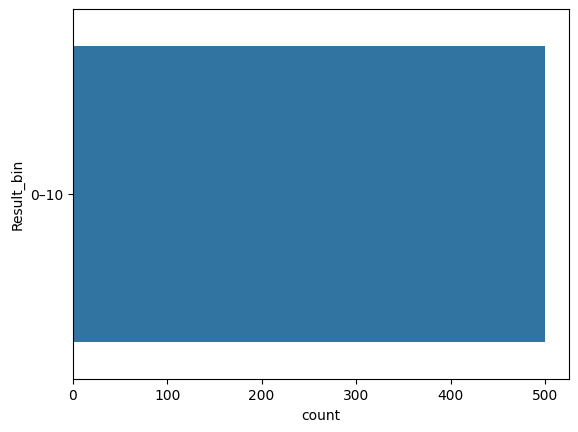

In [11]:
sns.countplot(sampled_data['Result_bin'])

In [13]:
print(df['district'].value_counts().count())
print(df['technology'].value_counts().count())

36
3


In [14]:
print(sampled_data['district'].value_counts().count())
print(sampled_data['technology'].value_counts().count())

36
3
